In [2]:
import sys
import os
import numpy as np
import random
# Go one level up to the 'main' directory
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add this directory to the Python path
if project_root not in sys.path:
    sys.path.append(project_root)


In [3]:

from scipy.optimize import brentq

from qiskit import transpile
from qiskit.quantum_info import SparsePauliOp
from qiskit.synthesis import SuzukiTrotter, LieTrotter
from qiskit.visualization import plot_histogram
from qiskit_aer import Aer

from helper import calc_gamma
from gqw_ansatz import GQWAnsatz



In [30]:
reps = 10
T = 2.5
delta_t =  ( T /reps)

# note: here we test out only the ansatz with initial set of lambda vector, these lambdas are not optimized to get the optimal hopping parameter set 
lambda_vec = [round(random.uniform(0, 1), 3) for i in range(4)] + [round(random.random(), 3) for _ in range(2)]

hopping_rate = [calc_gamma(i*delta_t, T, lambda_vec) for i in range(reps)]
cost_operator = SparsePauliOp(['IIIIZ', 'IIIZI', 'IIZII', 'IZIII', 'ZIIII', 'IIIZZ', 'IIZIZ', 'IZIIZ', 'ZIIIZ', 'IIZZI', 'IZIZI', 'ZIIZI', 'IZZII', 'ZIZII', 'ZZIII'],
              coeffs=[-2.17859671+0.j, -1.8058102 +0.j, -1.4477227 +0.j, -2.17335664+0.j,
 -1.71807745+0.j,  2.08131781+0.j,  2.08221245+0.j,  2.08198895+0.j,
  2.08346173+0.j,  2.07711691+0.j,  2.08177769+0.j,  2.08500311+0.j,
  2.0836148 +0.j,  2.08207505+0.j,  2.08628862+0.j])

evolution = LieTrotter()
# evolution = None
ansatz = GQWAnsatz(cost_operator, hopping_rate=hopping_rate, reps = reps, time = T, flatten= False, evolution= evolution)

h_parameters = [
 -1*delta_t * calc_gamma( i * delta_t, T, lambda_vec) for i in range (reps)
] + [delta_t for _ in range(reps)]

ansatz.num_parameters
ansatz.assign_parameters(h_parameters, inplace= True)


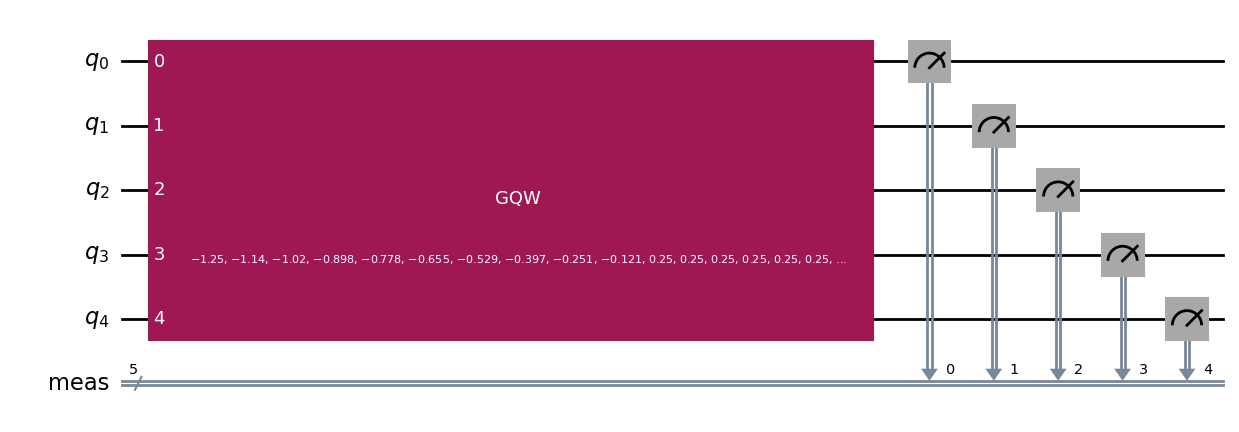

In [31]:
ansatz.measure(range(5), range(5))
ansatz.draw('mpl')

In [32]:
sim = Aer.get_backend('aer_simulator')

transpiled_qc = transpile(ansatz.decompose().decompose(), sim)   
trans_tot_gate_count = transpiled_qc.size()
trans_circuit_depth = transpiled_qc.depth()
trans_operations = transpiled_qc.count_ops()
print(f"Total gate counts: {trans_tot_gate_count}")
print(f"Circuit Depth: {trans_circuit_depth}")
print(f"Set of Operations: {dict(trans_operations)}")

Total gate counts: 160
Circuit Depth: 64
Set of Operations: {'rzz': 100, 'u3': 45, 'u2': 5, 'rx': 5, 'measure': 5}


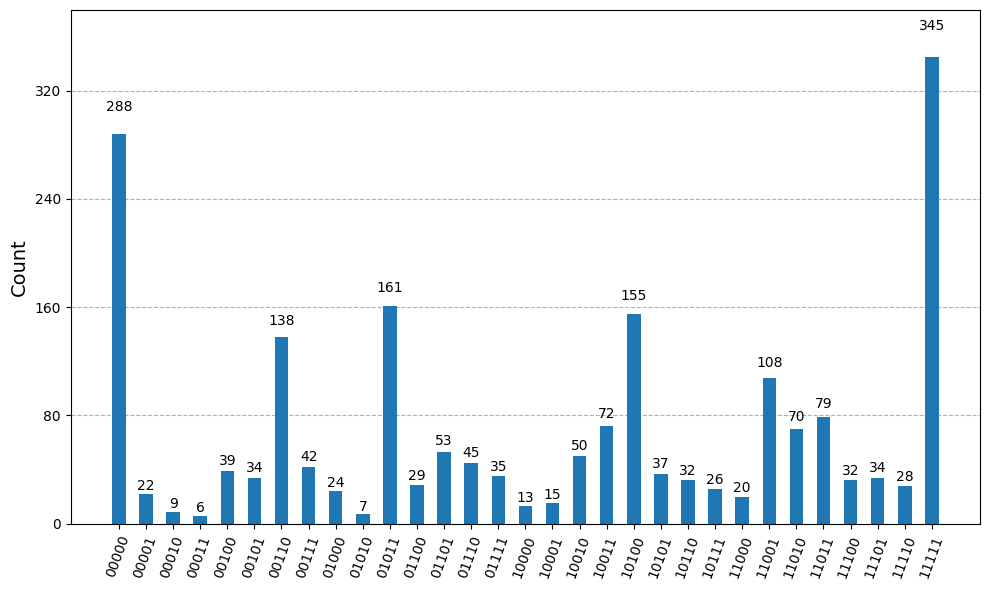

In [37]:
 
result = sim.run(ansatz.decompose().decompose(), shots = 2048).result()
counts = result.get_counts()


plot_histogram(counts, figsize= (10, 6))